In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestRegressor
import time
import warnings # prevent warnings
import joblib
from sklearn import metrics

In [2]:
site = 'C'

In [3]:
import sys

# load the data
# get parent directory
os.chdir("../..")
data_directory = 'Data_clean'
data_name = site + '_data_clean.csv'

data = pd.read_csv(os.path.join(os.getcwd(), data_directory, data_name), index_col = 0)

# reset to current directory
fd = sys.path[0]
os.chdir(fd)

In [4]:
# load train data to calculate variance using train data
data_train = pd.read_csv("data_train.csv", index_col = 0)

In [5]:
# drop irrelevant columns
data = data.drop(columns = ['Wind_speed_sd', 'TI'])

In [6]:
# Add week number
data['ts'] = pd.to_datetime(data['ts'], format = '%Y-%m-%d %H:%M:%S')
data['Week'] = data.ts.dt.isocalendar().week

# Rearrange columns
data = data.reindex(columns = ['ts', 'Month', 'Day', 'Hour', 'Week', 'instanceID', 'Wind_speed', 'Temperature', 'Power'])

In [7]:
# load trained models 
forest_all = joblib.load("forest_all.pkl")

In [8]:
data_train

,ts,Month,Day,Hour,instanceID,Wind_speed,Temperature,Power
395052,2020-05-10 15:20:00,5,10,15,C_WTG01,7.900000,7.738333,1161.069946
489027,2020-06-10 17:10:00,6,10,17,C_WTG01,6.137338,11.253334,431.023064
815535,2020-09-26 16:30:00,9,26,16,C_WTG01,2.981927,15.045000,22.673340
600978,2020-07-17 17:40:00,7,17,17,C_WTG01,3.696848,14.026667,73.544284
751359,2020-09-05 11:10:00,9,5,11,C_WTG01,7.433360,12.183333,950.906729
...,...,...,...,...,...,...,...,...
48845,2020-01-17 03:30:00,1,17,3,C_WTG21,5.888219,5.418333,562.047208
593165,2020-07-15 03:30:00,7,15,3,C_WTG21,4.657002,11.220000,210.426899
546713,2020-06-29 18:50:00,6,29,18,C_WTG21,10.369692,10.800000,1990.417444
861167,2020-10-11 18:30:00,10,11,18,C_WTG21,3.429893,9.196666,65.283786


In [9]:
data_train.iloc[:, 5:-1]

,Wind_speed,Temperature
395052,7.900000,7.738333
489027,6.137338,11.253334
815535,2.981927,15.045000
600978,3.696848,14.026667
751359,7.433360,12.183333
...,...,...
48845,5.888219,5.418333
593165,4.657002,11.220000
546713,10.369692,10.800000
861167,3.429893,9.196666


In [10]:
%%time
############################################## predict using train ################################################### 

turbines = data.instanceID.unique()
results = pd.DataFrame

for ID in turbines:
    
    # select data based on turbine ID
    data_temp = data_train[data_train['instanceID'] == ID]
    
    # get X
    X = data_temp.iloc[:, 5:-1].values
    
    # load model based on turbine number
    forest_temp = forest_all[ID]

    # predict
    pred = forest_temp.predict(X)

    data_temp = pd.concat([data_temp, pd.Series(pred, index = data_temp.index.values, name = 'Predicted_power')], 
                          axis = 1)
    
    if results.empty: 
        results = data_temp
    else:
        results = pd.concat([results, data_temp], axis = 0)
    
    print('Done ', ID)

Done  C_WTG02
Done  C_WTG04
Done  C_WTG05
Done  C_WTG06
Done  C_WTG07
Done  C_WTG08
Done  C_WTG09
Done  C_WTG12
Done  C_WTG13
Done  C_WTG17
Done  C_WTG16
Done  C_WTG21
Done  C_WTG10
Done  C_WTG11
Done  C_WTG01
Done  C_WTG18
Done  C_WTG19
Done  C_WTG14
Done  C_WTG15
Done  C_WTG20
Done  C_WTG03
Wall time: 3.34 s


In [11]:
results.head()

,ts,Month,Day,Hour,instanceID,Wind_speed,Temperature,Power,Predicted_power
410299,2020-05-15 16:20:00,5,15,16,C_WTG02,7.184900,7.136207,1096.866811,1024.601813
890758,2020-10-21 13:30:00,10,21,13,C_WTG02,3.264120,10.820000,31.812128,44.104614
320020,2020-04-15 19:50:00,4,15,19,C_WTG02,3.461468,6.300000,104.291399,81.850566
332053,2020-04-19 19:20:00,4,19,19,C_WTG02,9.210330,10.166667,1900.354159,1768.570446
648292,2020-08-02 09:10:00,8,2,9,C_WTG02,3.642551,13.145000,74.006387,80.868230


In [12]:
# create dataframe for the results
results = results.assign(Error = results['Predicted_power'] - results['Power'])

In [13]:
# define sigma 
sigma_3 = 3*results['Error'].std()
sigma_2 = 2*results['Error'].std()
sigma_1 = 1*results['Error'].std()

In [14]:
data.iloc[:, 6:-1]

,Wind_speed,Temperature
1,4.062859,4.273333
3,4.695373,5.270000
4,3.614577,5.451667
5,3.526409,5.393333
6,4.067837,5.593333
...,...,...
1106799,7.277958,3.032759
1106800,3.293306,3.100000
1106802,6.826774,2.510345
1106803,6.148926,3.451724


In [15]:
%%time
########################################### predict entire dataset ################################################### 

turbines = data.instanceID.unique()
results_all = pd.DataFrame

for ID in turbines:
    
    # select data based on turbine ID
    data_temp = data[data['instanceID'] == ID]
    
    # get X
    X = data_temp.iloc[:, 6:-1].values
    
    # load model based on turbine number
    forest_temp = forest_all[ID]

    # predict
    pred = forest_temp.predict(X)

    data_temp = pd.concat([data_temp, pd.Series(pred, index = data_temp.index.values, name = 'Predicted_power')], 
                          axis = 1)
    
    if results_all.empty: 
        results_all = data_temp
    else:
        results_all = pd.concat([results_all, data_temp], axis = 0)
    
    print('Done ', ID)

Done  C_WTG02
Done  C_WTG04
Done  C_WTG05
Done  C_WTG06
Done  C_WTG07
Done  C_WTG08
Done  C_WTG09
Done  C_WTG12
Done  C_WTG13
Done  C_WTG17
Done  C_WTG16
Done  C_WTG21
Done  C_WTG10
Done  C_WTG11
Done  C_WTG01
Done  C_WTG18
Done  C_WTG19
Done  C_WTG14
Done  C_WTG15
Done  C_WTG20
Done  C_WTG03
Wall time: 5.92 s


In [16]:
# create dataframe for the results_all
results_all = results_all.assign(Error = results_all['Predicted_power'] - results_all['Power'])

In [17]:
results_all = results_all.assign(UWL = results_all['Predicted_power'] + sigma_2)
results_all = results_all.assign(LWL = results_all['Predicted_power'] - sigma_2)

In [18]:
# create dataframe for the results
results_all = results_all.assign(CI_width = results_all['UWL'] - results_all['LWL'])

# classify outlier 
results_all['Outlier_pred'] = (results_all['Power'] < results_all['LWL']) | (results_all['Power'] > results_all['UWL'])
results_all['Under_pred'] = (results_all['Power'] < results_all['LWL'])
results_all['Over_pred'] = (results_all['Power'] > results_all['UWL'])
results_all['Sample_count'] = 1

In [19]:
# create dataframe for normal and outlier data     
outlier_all = results_all[(results_all['Under_pred'] == 1) | (results_all['Over_pred'] == 1)]
outlier_under = results_all[results_all['Under_pred'] == 1]
outlier_over = results_all[results_all['Over_pred'] == 1]

In [30]:
MSE = metrics.mean_squared_error(results_all['Power'], results_all['Predicted_power'])
RMSE = np.sqrt(metrics.mean_squared_error(results_all['Power'], results_all['Predicted_power']))
MAE = metrics.mean_absolute_error(results_all['Power'], results_all['Predicted_power'])
MedAE = metrics.median_absolute_error(results_all['Power'], results_all['Predicted_power'])

print('MSE:', MSE)
print('RMSE:', RMSE)
print('MAE:', MAE)
print('MedAE:', MedAE)

MSE: 3771.9601066303126
RMSE: 61.41628535356329
MAE: 43.31598457521916
MedAE: 29.23591109644326


In [31]:
results_T01 = results_all[results_all['instanceID'] == site + "_WTG01"]
MSE = metrics.mean_squared_error(results_T01['Power'], results_T01['Predicted_power'])
RMSE = np.sqrt(metrics.mean_squared_error(results_T01['Power'], results_T01['Predicted_power']))
MAE = metrics.mean_absolute_error(results_T01['Power'], results_T01['Predicted_power'])
MedAE = metrics.median_absolute_error(results_T01['Power'], results_T01['Predicted_power'])

print('MSE:', MSE)
print('RMSE:', RMSE)
print('MAE:', MAE)
print('MedAE:', MedAE)

MSE: 3616.4137089165097
RMSE: 60.136625353577244
MAE: 42.00670869046807
MedAE: 27.964374071529292


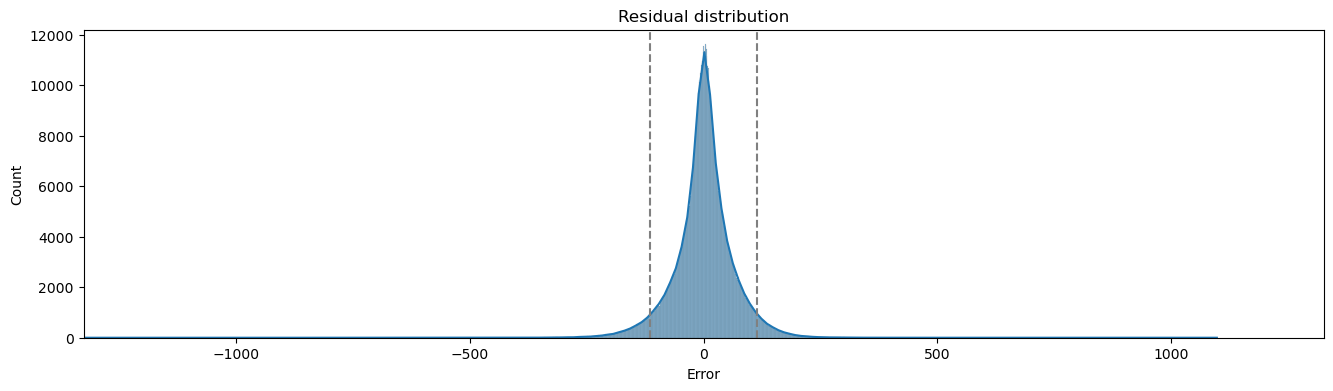

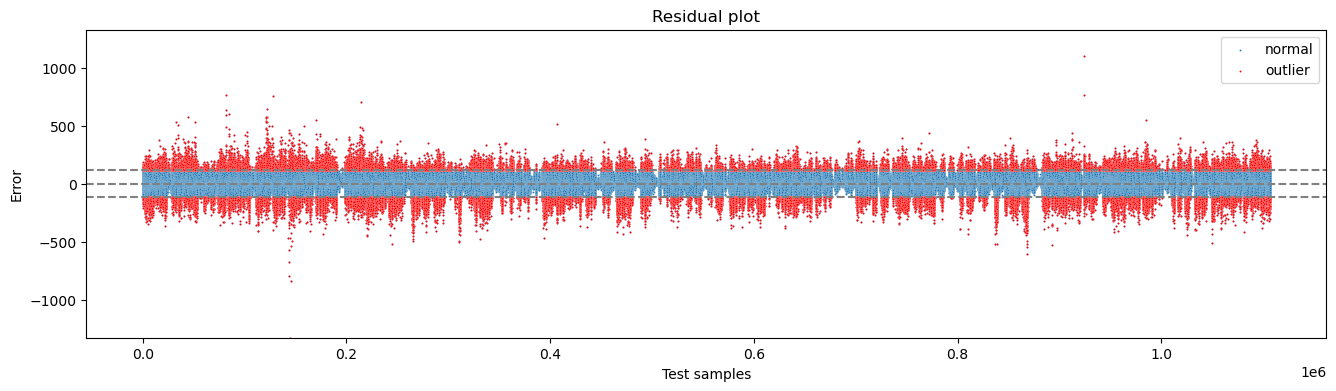

In [20]:
plt.subplots(figsize = (16,4))
sns.histplot(data = results_all, x = 'Error', kde = True)
plt.axvline(x = -sigma_2, color = 'gray', linestyle = '--')
plt.axvline(x = sigma_2, color = 'gray', linestyle = '--')
plt.xlim(-max(abs(results_all.Error.max()), abs(results_all.Error.min())), 
         max(abs(results_all.Error.max()), abs(results_all.Error.min())))
plt.title('Residual distribution')
plt.show()

temp = results_all[results_all['Outlier_pred'] == 1]
plt.subplots(figsize = (16,4))
sns.scatterplot(data = results_all, x = results_all.index.values, y = results_all['Error'], s=2, label = 'normal')
sns.scatterplot(data = temp, x = temp.index.values, y = temp['Error'], color = 'red', s=2, label = 'outlier')
plt.axhline(y = -sigma_2, color = 'gray', linestyle = '--')
plt.axhline(y = sigma_2, color = 'gray', linestyle = '--')
plt.axhline(y = 0, color = 'gray', linestyle = '--')
plt.ylim(-max(abs(results_all.Error.max()), abs(results_all.Error.min())), 
         max(abs(results_all.Error.max()), abs(results_all.Error.min())))
plt.xlabel('Test samples')
plt.title('Residual plot')
plt.legend()
plt.show()


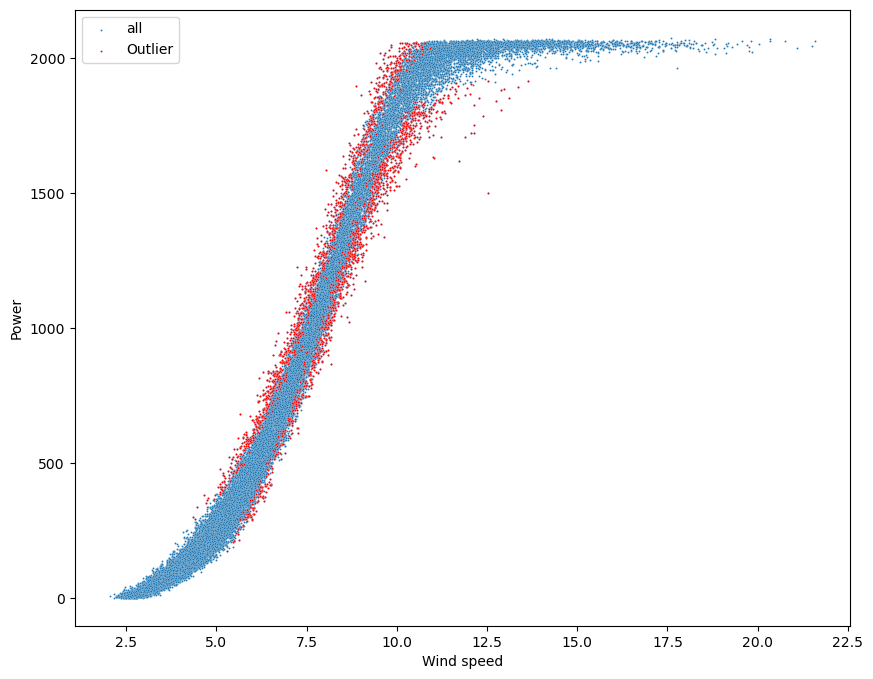

In [21]:
temp_data = results_all[results_all['instanceID'] == site + '_WTG05']
temp_outlier = temp_data[(temp_data['Under_pred'] == 1) | (temp_data['Over_pred'] == 1)]

plt.subplots(figsize = (10,8))
sns.scatterplot( data = temp_data, x = 'Wind_speed', y = 'Power', s = 2, label = 'all')
sns.scatterplot( data = temp_outlier, x = 'Wind_speed', y = 'Power', s = 2, label = 'Outlier', color = "Red")
plt.xlabel('Wind speed')
plt.ylabel('Power')
plt.legend()
# plt.title('Outliers identified by Control Charts')
plt.show()

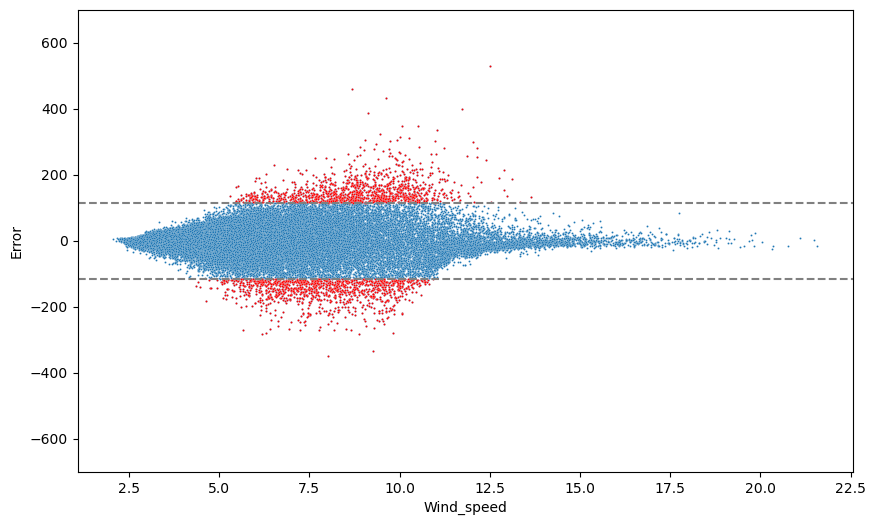

In [22]:
plt.subplots(figsize=(10, 6))
sns.scatterplot(data = temp_data, x = "Wind_speed", y = "Error", s = 2)
sns.scatterplot(data = temp_outlier, x = "Wind_speed", y = "Error", s = 2, color = "red")
plt.axhline(y = sigma_2, color = 'gray', linestyle = '--')
plt.axhline(y = -sigma_2, color = 'gray', linestyle = '--')
plt.ylim([-700, 700])
plt.show()

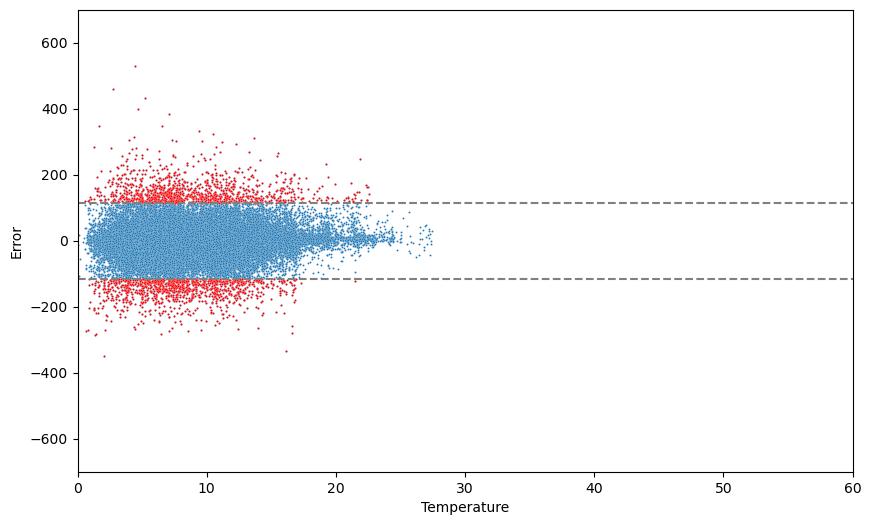

In [23]:
plt.subplots(figsize=(10, 6))
sns.scatterplot(data = temp_data, x = "Temperature", y = "Error", s = 2)
sns.scatterplot(data = temp_outlier, x = "Temperature", y = "Error", s = 2, color = "red")
plt.axhline(y = sigma_2, color = 'gray', linestyle = '--')
plt.axhline(y = -sigma_2, color = 'gray', linestyle = '--')
plt.ylim([-700, 700])
plt.xlim([0, 60])
plt.show()